<div style="text-align: center;">
    <h1 style="font-size: 30px; font-weight:bold">ETE II (CAT 2)</h1>
    <h3 style="font-size: 20px;">R Abhijit Srivathsan - 2448044</h3>
</div>


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# For modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style for visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

## Loading the dataset

In [4]:
# =============================================================================
# DATA LOADING AND INITIAL EXPLORATION
# =============================================================================

# Fetch dataset from UCI ML Repository
real_estate_valuation = fetch_ucirepo(id=477) 

# Extract features and target
X = real_estate_valuation.data.features 
y = real_estate_valuation.data.targets 

# Display metadata and variables information
print("=== Dataset Metadata ===")
print(real_estate_valuation.metadata)
print("\n=== Variable Information ===")
print(real_estate_valuation.variables)

# Combine features and target for easier data exploration
df = pd.concat([X, y], axis=1)

# Display the first few rows of the dataset
print("\n=== First 5 rows of the dataset ===")
print(df.head())

# Display basic information about the dataset
print("\n=== Dataset Information ===")
print(df.info())

# Display summary statistics
print("\n=== Summary Statistics ===")
print(df.describe())

# Check for missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())

=== Dataset Metadata ===
{'uci_id': 477, 'name': 'Real Estate Valuation', 'repository_url': 'https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set', 'data_url': 'https://archive.ics.uci.edu/static/public/477/data.csv', 'abstract': 'The real estate valuation is a regression problem. The market historical data set of real estate valuation are collected from Sindian Dist., New Taipei City, Taiwan. ', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 414, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Y house price of unit area'], 'index_col': ['No'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C5J30W', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 373, 'type': 'NATIVE', 'title': 'Building real estate valuation models with comparative approach through case-based reaso

## Performing **EDA**


=== EXPLORATORY DATA ANALYSIS ===


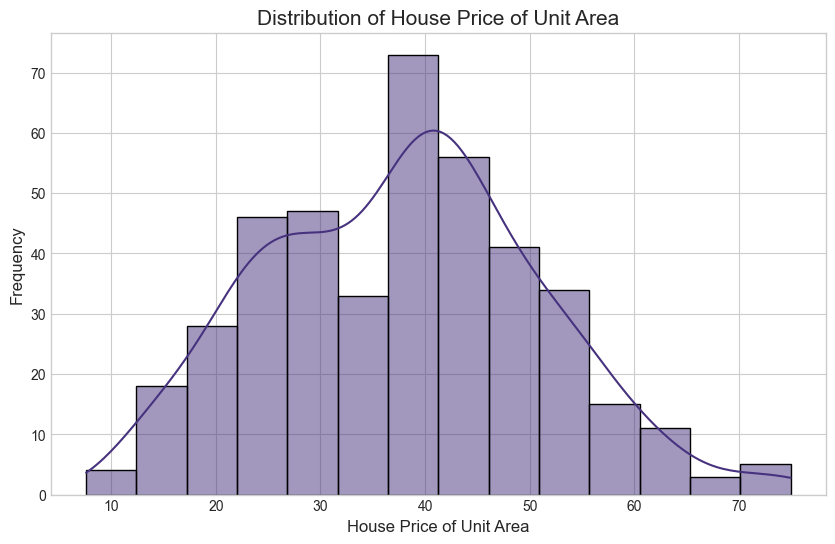

<Figure size 1000x600 with 0 Axes>

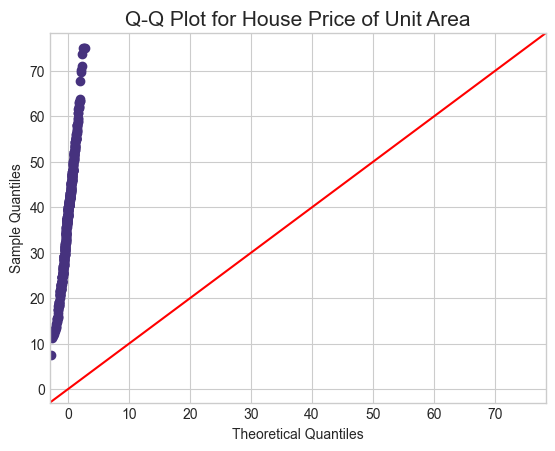

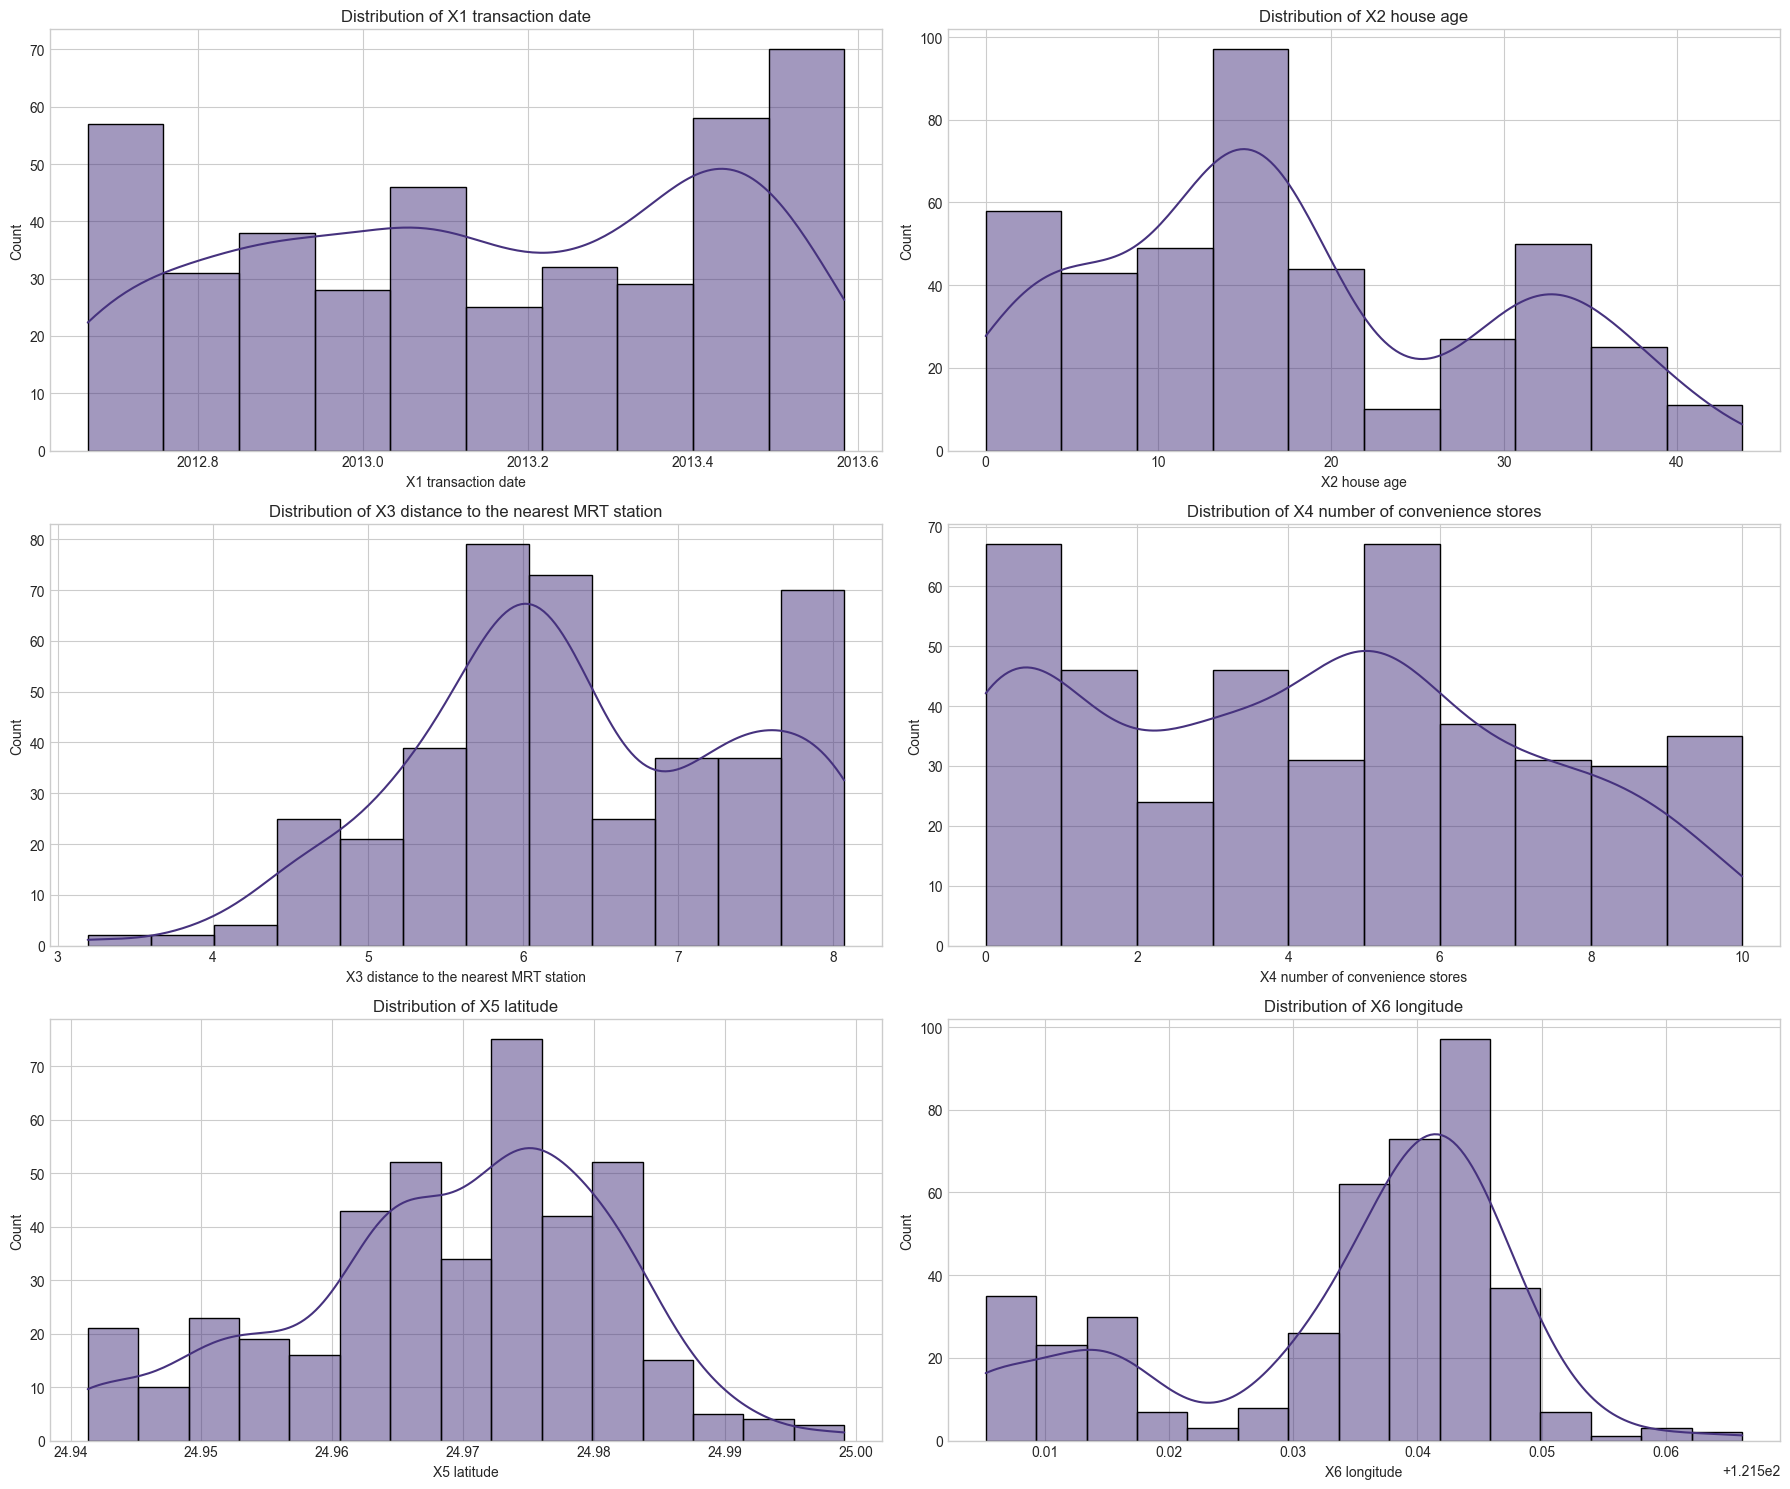

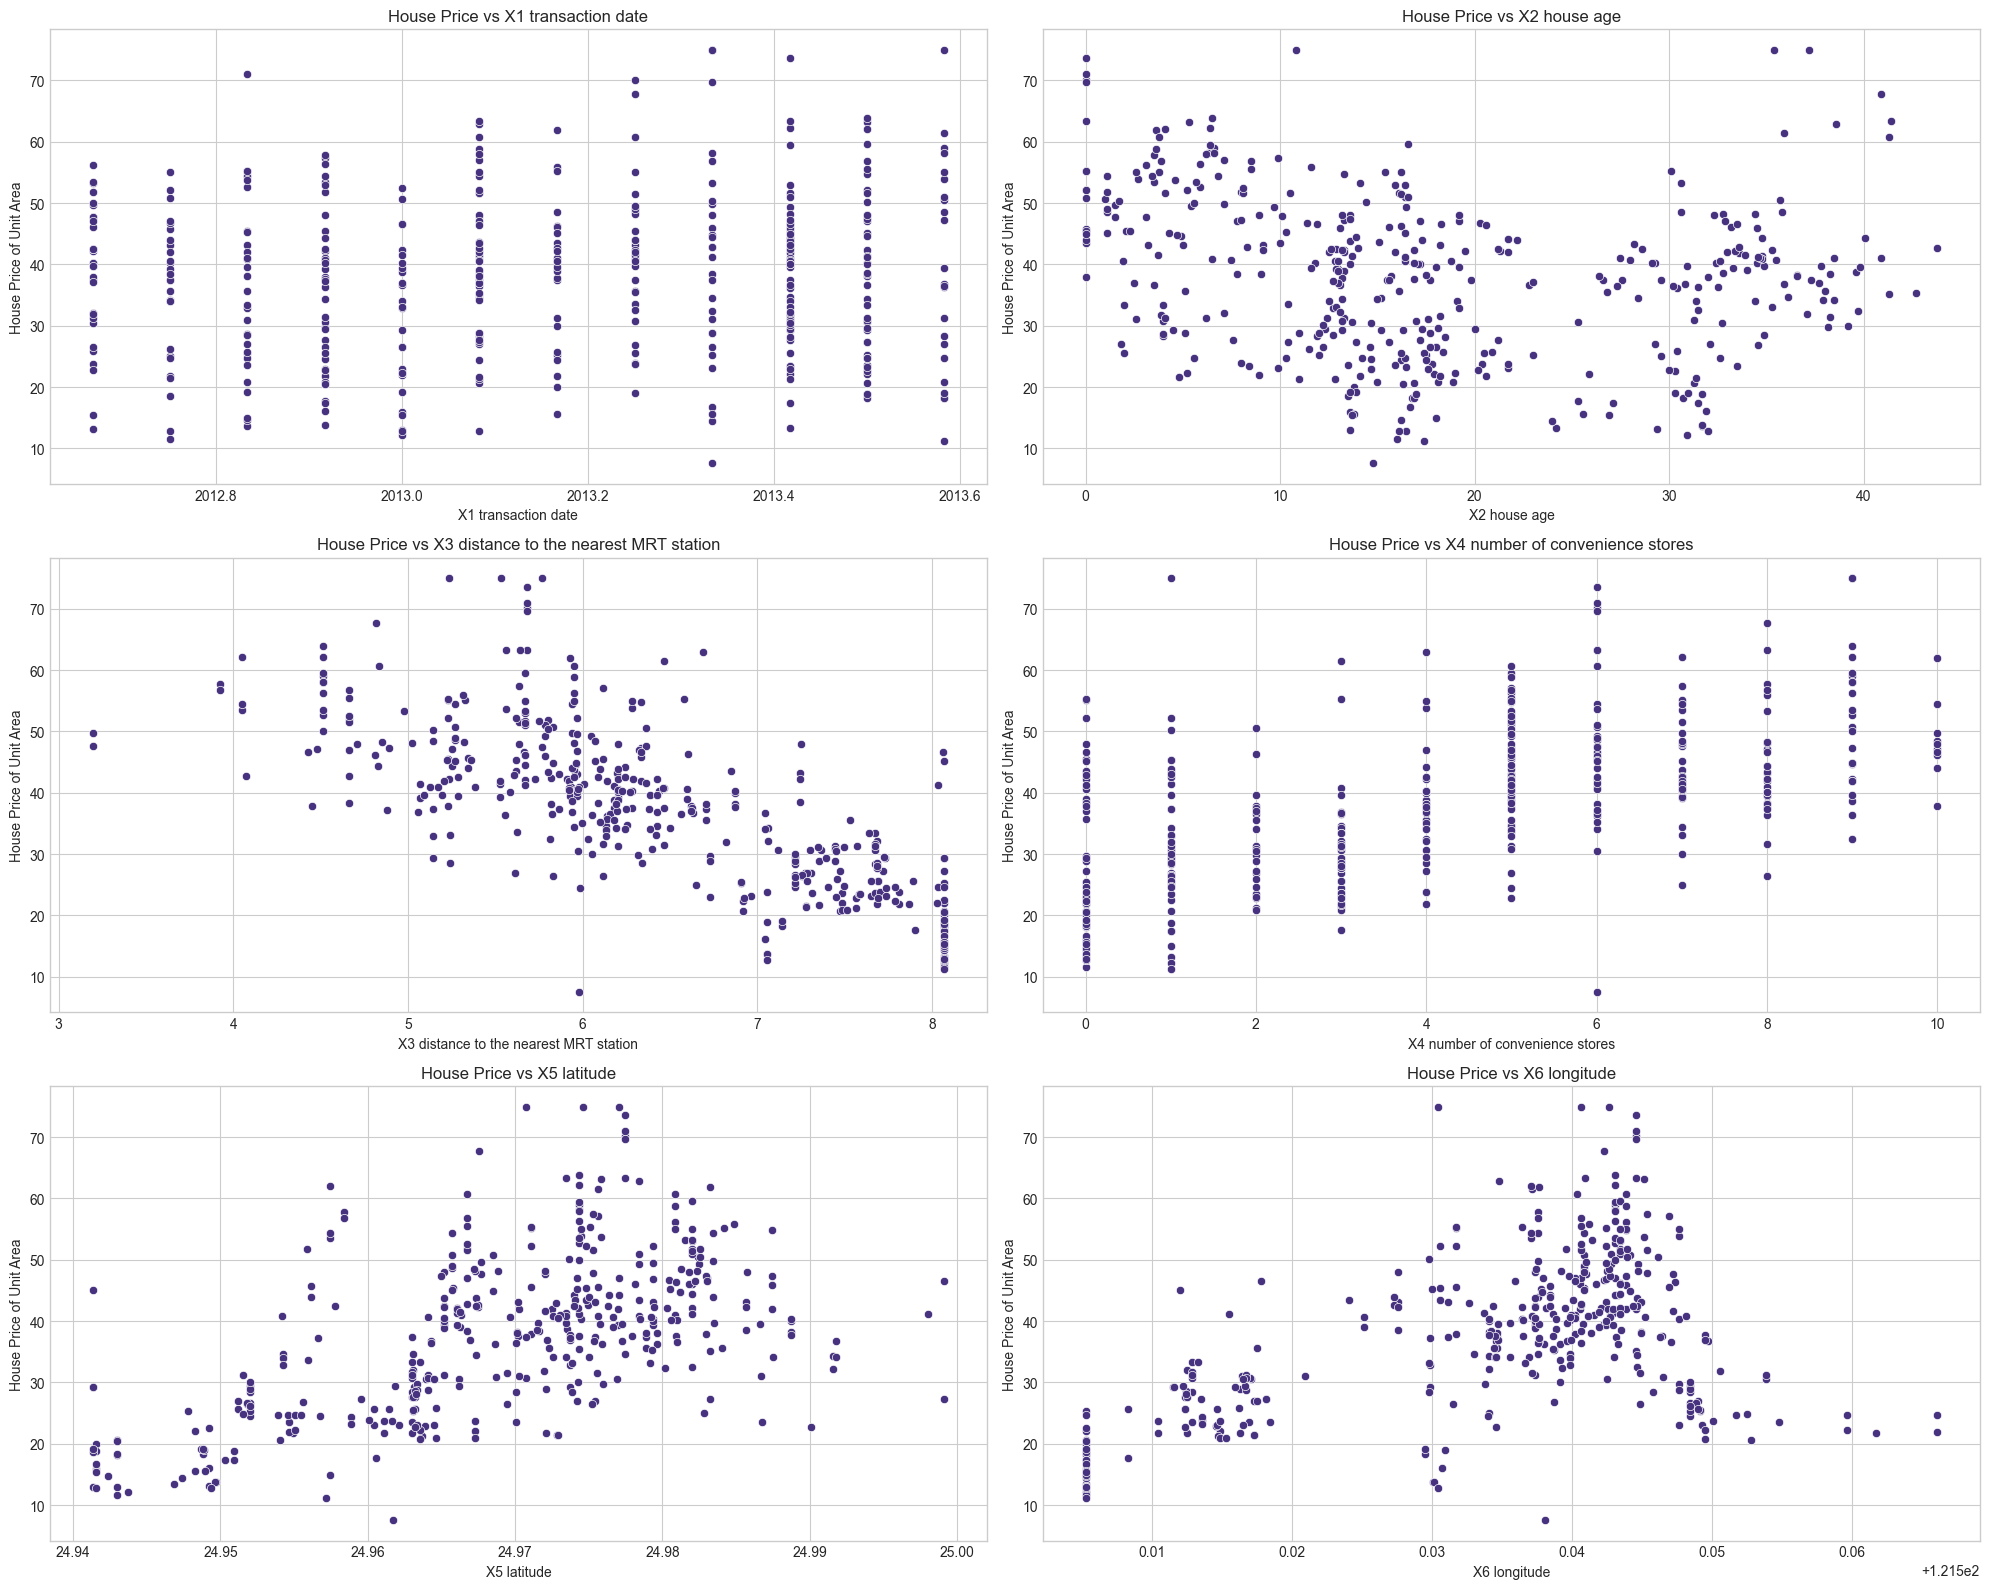

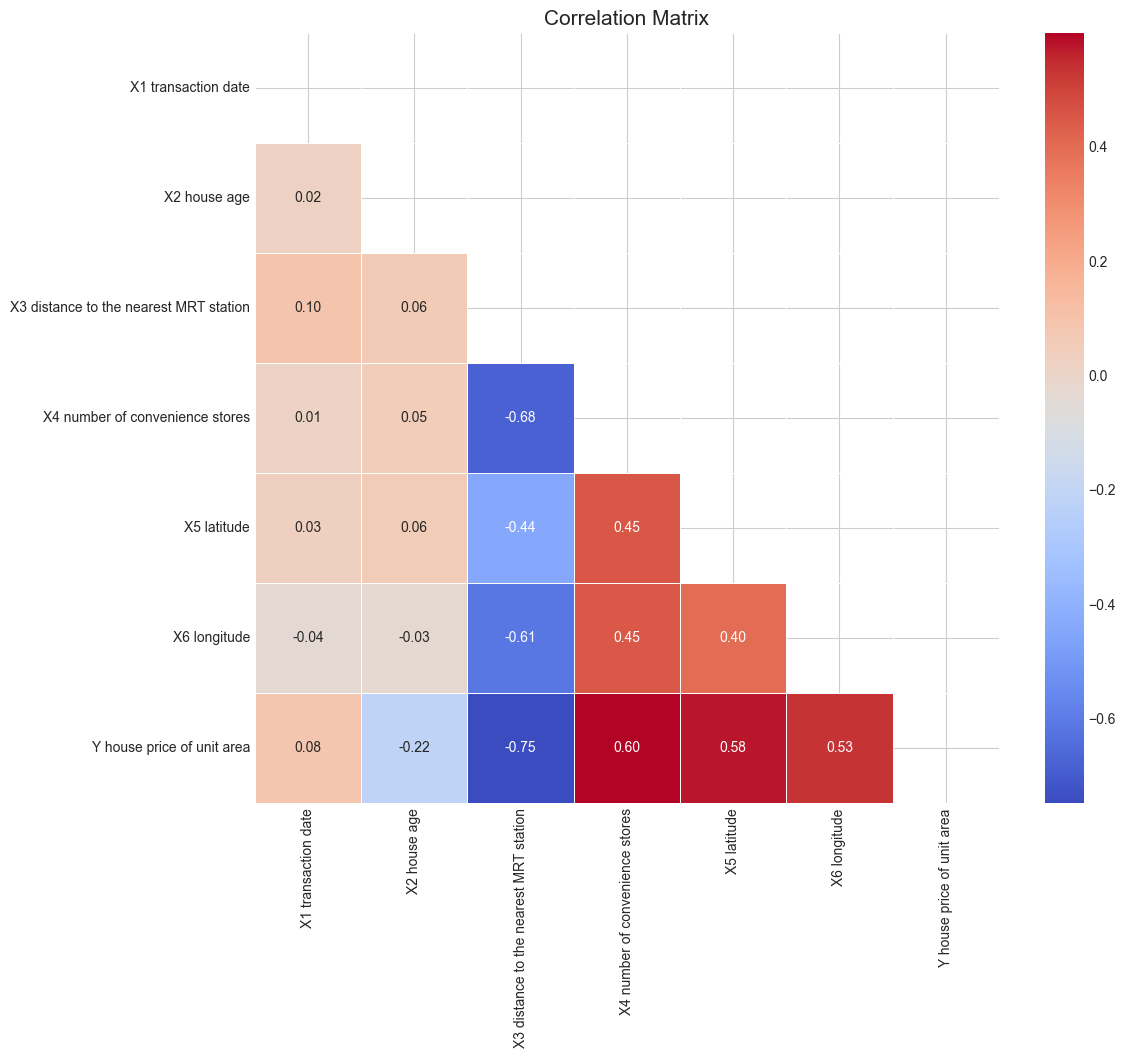


=== Correlation with Target Variable ===
Y house price of unit area                1.000000
X4 number of convenience stores           0.598823
X5 latitude                               0.576873
X6 longitude                              0.531645
X1 transaction date                       0.084391
X2 house age                             -0.215673
X3 distance to the nearest MRT station   -0.748606
Name: Y house price of unit area, dtype: float64


<Figure size 1400x1200 with 0 Axes>

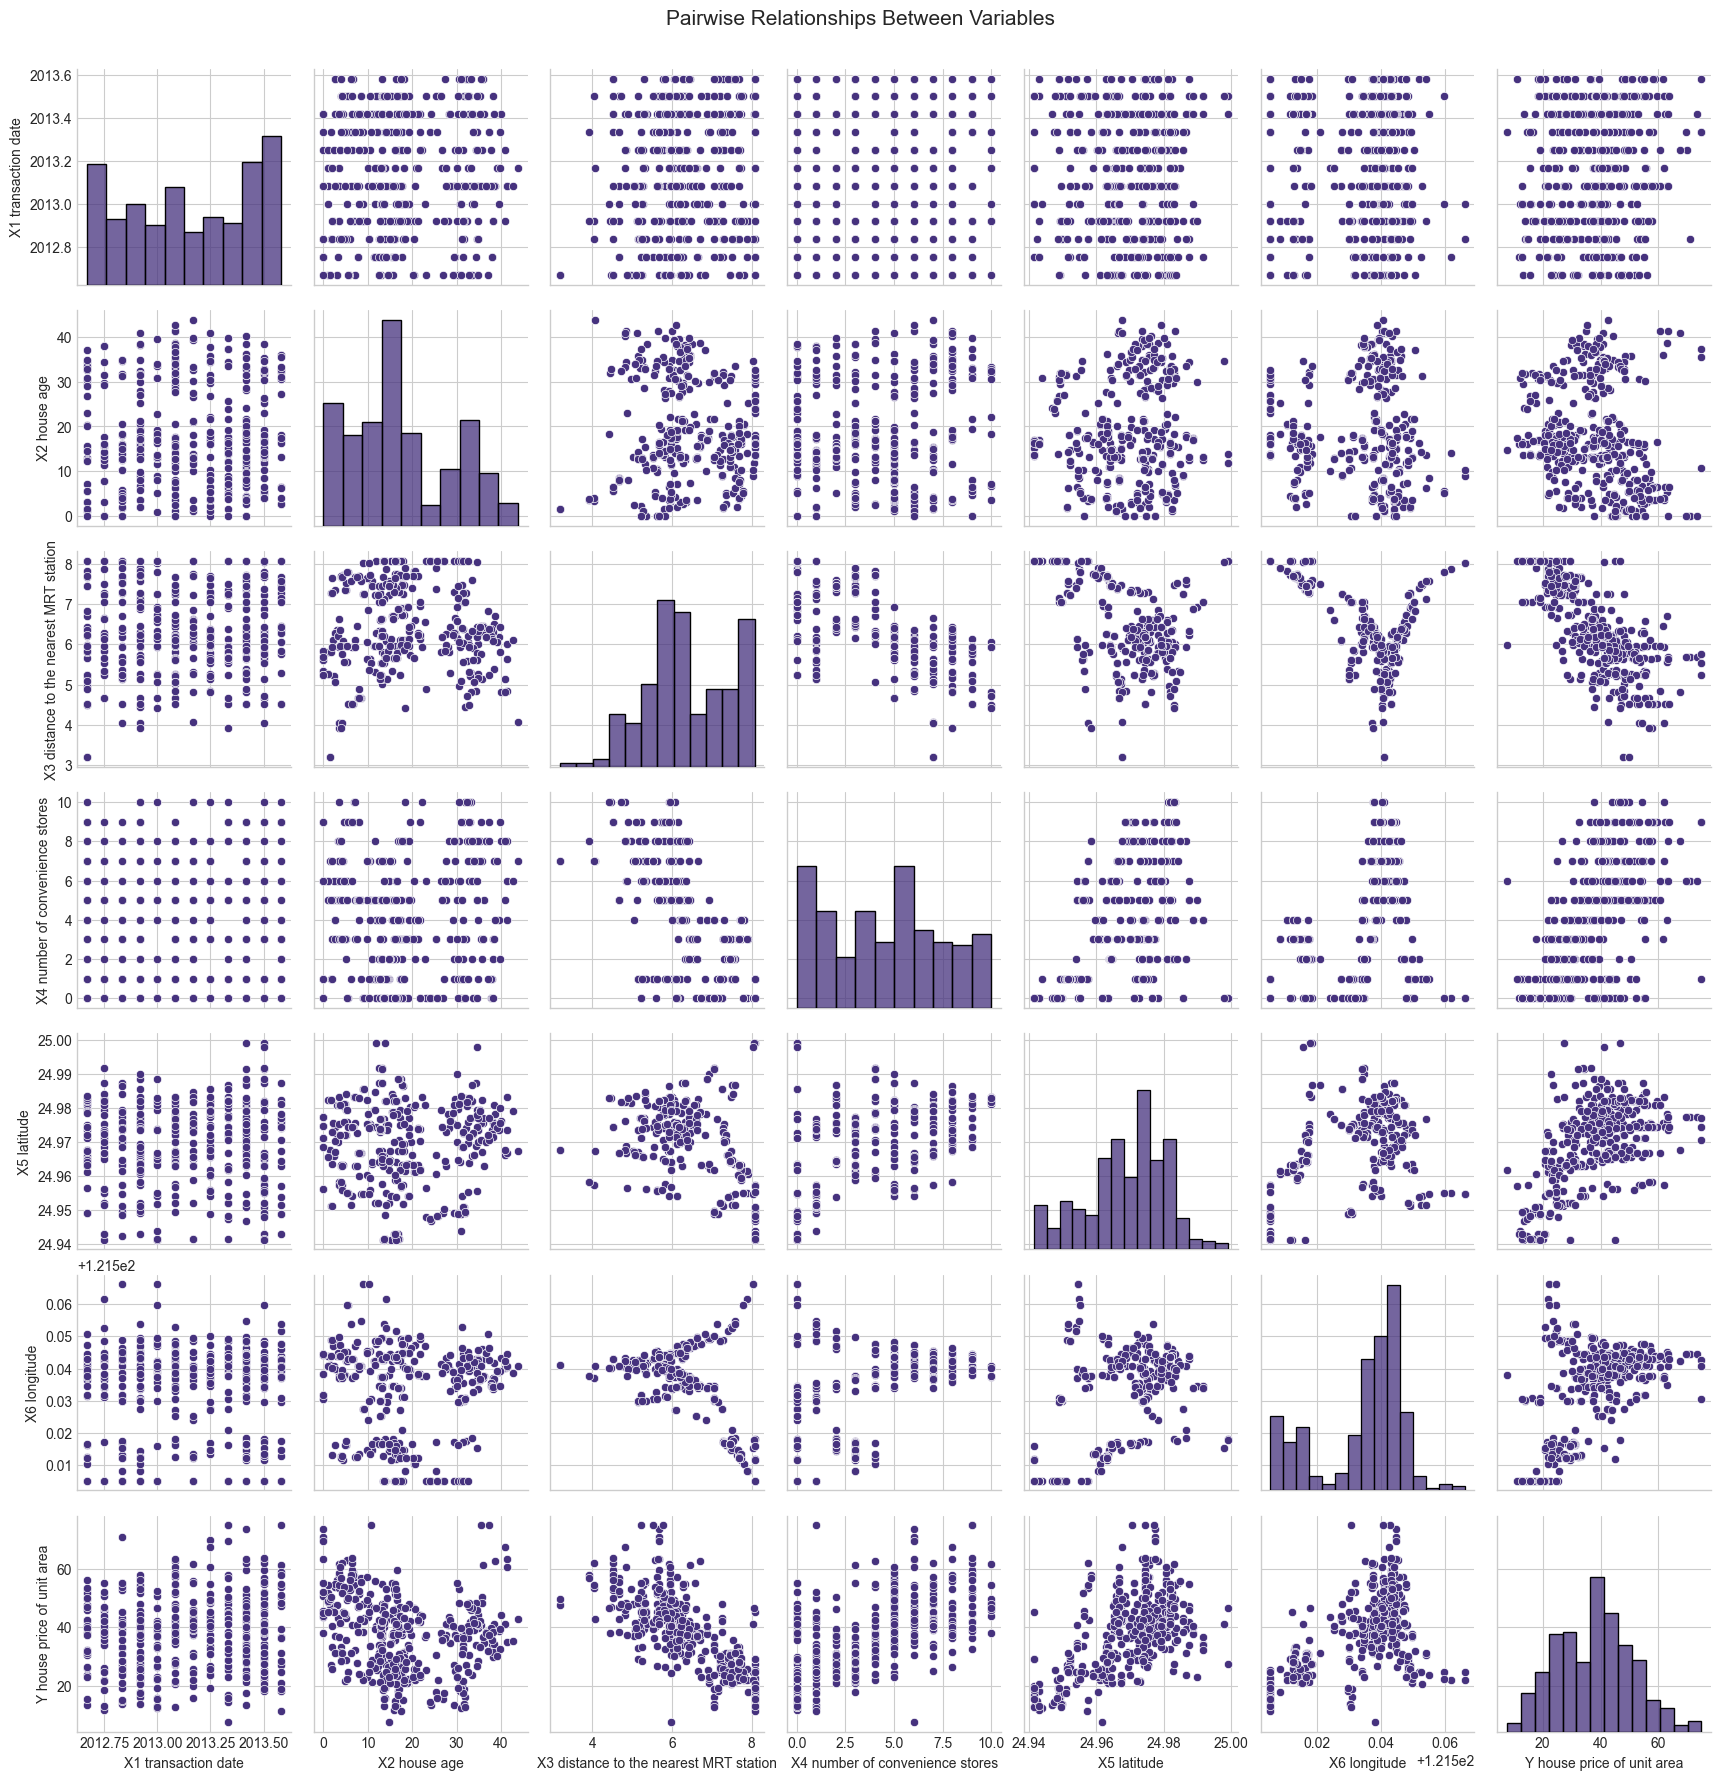

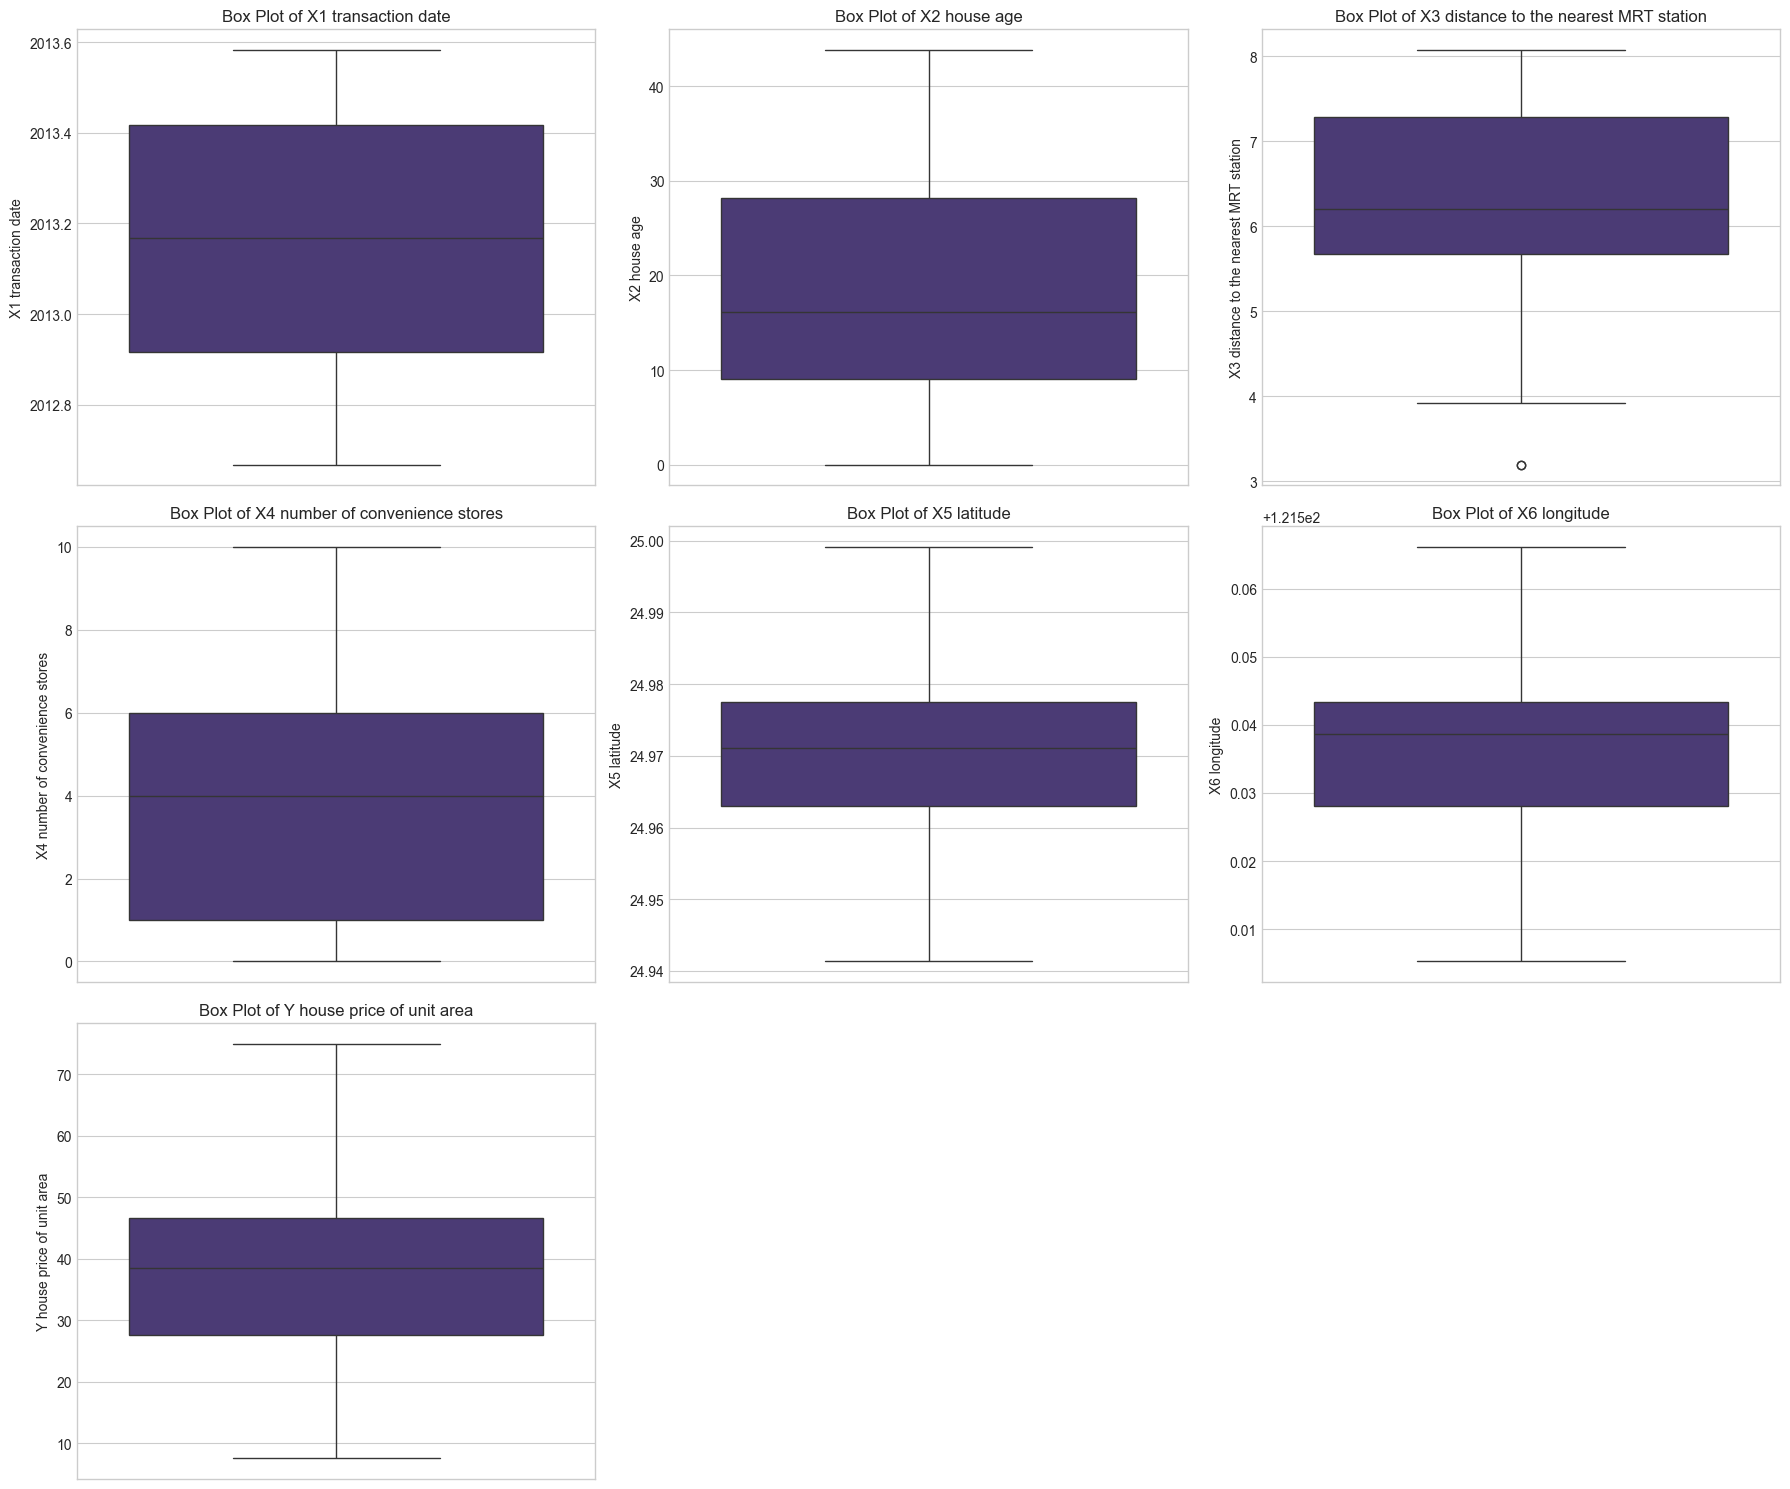

In [16]:
# =============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Understanding the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Y house price of unit area'], kde=True)
plt.title('Distribution of House Price of Unit Area', fontsize=15)
plt.xlabel('House Price of Unit Area', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Check if the target variable is normally distributed using Q-Q plot
plt.figure(figsize=(10, 6))
sm.qqplot(df['Y house price of unit area'], line='45')
plt.title('Q-Q Plot for House Price of Unit Area', fontsize=15)
plt.show()

# Explore the distribution of each numerical feature
plt.figure(figsize=(18, 15))
for i, column in enumerate(X.columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}', fontsize=12)
plt.tight_layout()
plt.show()

# Explore the relationship between features and target
plt.figure(figsize=(20, 16))
for i, column in enumerate(X.columns):
    plt.subplot(3, 2, i+1)
    sns.scatterplot(x=df[column], y=df['Y house price of unit area'])
    plt.title(f'House Price vs {column}', fontsize=12)
    plt.xlabel(column, fontsize=10)
    plt.ylabel('House Price of Unit Area', fontsize=10)
plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=15)
plt.show()

# Print the correlation with target
print("\n=== Correlation with Target Variable ===")
correlations = df.corr()['Y house price of unit area'].sort_values(ascending=False)
print(correlations)

# Pairplot for visualizing relationships between variables
plt.figure(figsize=(14, 12))
sns.pairplot(df, height=2.5)
plt.suptitle('Pairwise Relationships Between Variables', y=1.02, fontsize=15)
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(18, 15))
for i, column in enumerate(df.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[column])
    plt.title(f'Box Plot of {column}', fontsize=12)
plt.tight_layout()
plt.show()


## Data Preprocessing

In [6]:
# =============================================================================
# DATA PREPROCESSING
# =============================================================================

print("\n=== DATA PREPROCESSING ===")

# Function to detect outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Check for outliers in each feature
print("Outliers in each column:")
for column in df.columns:
    outliers = detect_outliers(df, column)
    print(f"{column}: {len(outliers)} outliers")

# We'll handle outliers by capping them at the boundaries
for column in df.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

print("\nOutliers have been handled by capping at IQR boundaries")

# Check for skewness in the data
print("\nSkewness in each column before transformation:")
print(df.skew())

# Apply log transformation to highly skewed columns (skewness > 0.5)
skewed_columns = df.skew()[df.skew() > 0.5].index.tolist()
print("\nApplying log transformation to highly skewed columns:", skewed_columns)

for column in skewed_columns:
    # Add a small constant to handle zero values
    if (df[column] <= 0).any():
        df[column] = np.log1p(df[column] - df[column].min() + 1)
    else:
        df[column] = np.log1p(df[column])

print("\nSkewness after transformation:")
print(df.skew())

# Split the data back into features and target
X_processed = df.drop(columns=['Y house price of unit area'])
y_processed = df['Y house price of unit area']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_processed.columns)

print("\nFeatures have been scaled. Sample of scaled features:")
print(X_scaled_df.head())


=== DATA PREPROCESSING ===
Outliers in each column:
X1 transaction date: 0 outliers
X2 house age: 0 outliers
X3 distance to the nearest MRT station: 37 outliers
X4 number of convenience stores: 0 outliers
X5 latitude: 8 outliers
X6 longitude: 35 outliers
Y house price of unit area: 3 outliers

Outliers have been handled by capping at IQR boundaries

Skewness in each column before transformation:
X1 transaction date                      -0.150572
X2 house age                              0.382926
X3 distance to the nearest MRT station    1.216473
X4 number of convenience stores           0.154607
X5 latitude                              -0.452286
X6 longitude                             -0.817837
Y house price of unit area                0.178463
dtype: float64

Applying log transformation to highly skewed columns: ['X3 distance to the nearest MRT station']

Skewness after transformation:
X1 transaction date                      -0.150572
X2 house age                              0.382

## Model Development

In [7]:
# =============================================================================
# MODEL DEVELOPMENT
# =============================================================================

print("\n=== MODEL DEVELOPMENT ===")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_processed, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# 1. Linear Regression (Baseline Model)
print("\n1. Baseline Model: Multiple Linear Regression")
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Evaluate the baseline model
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

print("Training R²:", r2_score(y_train, y_train_pred))
print("Testing R²:", r2_score(y_test, y_test_pred))
print("Training MSE:", mean_squared_error(y_train, y_train_pred))
print("Testing MSE:", mean_squared_error(y_test, y_test_pred))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Testing RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Testing MAE:", mean_absolute_error(y_test, y_test_pred))

# Display the coefficients
coef_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Coefficient': linear_reg.coef_
})
print("\nModel Coefficients:")
print(coef_df.sort_values(by='Coefficient', ascending=False))

# 2. Ridge Regression (L2 Regularization)
print("\n2. Ridge Regression with Cross-Validation")
ridge_alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = GridSearchCV(
    Ridge(), 
    param_grid={'alpha': ridge_alphas},
    cv=5, 
    scoring='neg_mean_squared_error'
)
ridge_cv.fit(X_train, y_train)

print("Best Ridge alpha:", ridge_cv.best_params_)
print("Best Ridge CV score:", -ridge_cv.best_score_)

# Evaluate Ridge regression with the best alpha
ridge_best = Ridge(alpha=ridge_cv.best_params_['alpha'])
ridge_best.fit(X_train, y_train)

y_train_pred_ridge = ridge_best.predict(X_train)
y_test_pred_ridge = ridge_best.predict(X_test)

print("Ridge Training R²:", r2_score(y_train, y_train_pred_ridge))
print("Ridge Testing R²:", r2_score(y_test, y_test_pred_ridge))
print("Ridge Training RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)))
print("Ridge Testing RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)))

# 3. Lasso Regression (L1 Regularization)
print("\n3. Lasso Regression with Cross-Validation")
lasso_alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
lasso_cv = GridSearchCV(
    Lasso(max_iter=10000), 
    param_grid={'alpha': lasso_alphas},
    cv=5, 
    scoring='neg_mean_squared_error'
)
lasso_cv.fit(X_train, y_train)

print("Best Lasso alpha:", lasso_cv.best_params_)
print("Best Lasso CV score:", -lasso_cv.best_score_)

# Evaluate Lasso regression with the best alpha
lasso_best = Lasso(alpha=lasso_cv.best_params_['alpha'], max_iter=10000)
lasso_best.fit(X_train, y_train)

y_train_pred_lasso = lasso_best.predict(X_train)
y_test_pred_lasso = lasso_best.predict(X_test)

print("Lasso Training R²:", r2_score(y_train, y_train_pred_lasso))
print("Lasso Testing R²:", r2_score(y_test, y_test_pred_lasso))
print("Lasso Training RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_lasso)))
print("Lasso Testing RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)))

# Check Lasso features (coefficients that are not zero)
lasso_coef_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Coefficient': lasso_best.coef_
})
print("\nLasso Coefficients (features with non-zero coefficients are selected):")
print(lasso_coef_df.sort_values(by='Coefficient', ascending=False))

# 4. Polynomial Regression
print("\n4. Polynomial Regression")
poly_degrees = [2, 3]
poly_pipelines = {}
poly_scores = {}

for degree in poly_degrees:
    # Create polynomial features
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Create pipeline
    pipeline = Pipeline([
        ('poly_features', polynomial_features),
        ('ridge', Ridge(alpha=ridge_cv.best_params_['alpha']))
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Store pipeline
    poly_pipelines[degree] = pipeline
    
    # Evaluate the model
    y_train_pred_poly = pipeline.predict(X_train)
    y_test_pred_poly = pipeline.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred_poly)
    test_r2 = r2_score(y_test, y_test_pred_poly)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
    
    poly_scores[degree] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }
    
    print(f"\nPolynomial Regression (degree {degree}):")
    print(f"Training R²: {train_r2}")
    print(f"Testing R²: {test_r2}")
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")

# Find the best polynomial model
best_degree = max(poly_scores, key=lambda k: poly_scores[k]['test_r2'])
print(f"\nBest Polynomial Degree: {best_degree} with Test R²: {poly_scores[best_degree]['test_r2']}")

# Select the best model based on test R²
models = {
    'Multiple Linear Regression': (linear_reg, y_test_pred),
    'Ridge Regression': (ridge_best, y_test_pred_ridge),
    'Lasso Regression': (lasso_best, y_test_pred_lasso),
    f'Polynomial Regression (degree {best_degree})': (poly_pipelines[best_degree], poly_pipelines[best_degree].predict(X_test))
}

model_scores = {
    model_name: r2_score(y_test, pred) 
    for model_name, (_, pred) in models.items()
}

best_model_name = max(model_scores, key=model_scores.get)
best_model, best_pred = models[best_model_name]

print(f"\nBest Model: {best_model_name} with Test R²: {model_scores[best_model_name]}")


=== MODEL DEVELOPMENT ===
Training set shape: (331, 6)
Testing set shape: (83, 6)

1. Baseline Model: Multiple Linear Regression
Training R²: 0.6897308062148817
Testing R²: 0.730844388929474
Training MSE: 53.28064142157157
Testing MSE: 45.15347654938312
Training RMSE: 7.299358973332629
Testing RMSE: 6.719633661843711
Training MAE: 5.122452736632397
Testing MAE: 4.294367556583202

Model Coefficients:
                                  Feature  Coefficient
4                             X5 latitude     3.814597
0                     X1 transaction date     1.660932
3         X4 number of convenience stores     1.186467
5                            X6 longitude     0.384734
1                            X2 house age    -2.799418
2  X3 distance to the nearest MRT station    -7.176842

2. Ridge Regression with Cross-Validation
Best Ridge alpha: {'alpha': 1}
Best Ridge CV score: 55.581342302221046
Ridge Training R²: 0.689724353236325
Ridge Testing R²: 0.7312740483564
Ridge Training RMSE: 7.299

## Model Evaluation


=== MODEL EVALUATION ===

Evaluation of Polynomial Regression (degree 3):
Cross-Validation R² Scores: [0.81255762 0.62479747 0.59072449 0.6764821  0.64183498]
Mean CV R²: 0.6692793328851522
Standard Deviation of CV R²: 0.07678963511064699

Training R²: 0.8156188937788452
Testing R²: 0.7944960571000381
Training MSE: 31.662645864499737
Testing MSE: 34.475288958801585
Training RMSE: 5.626957069722475
Testing RMSE: 5.871566141908101
Training MAE: 4.08485016502988
Testing MAE: 4.259784145664417


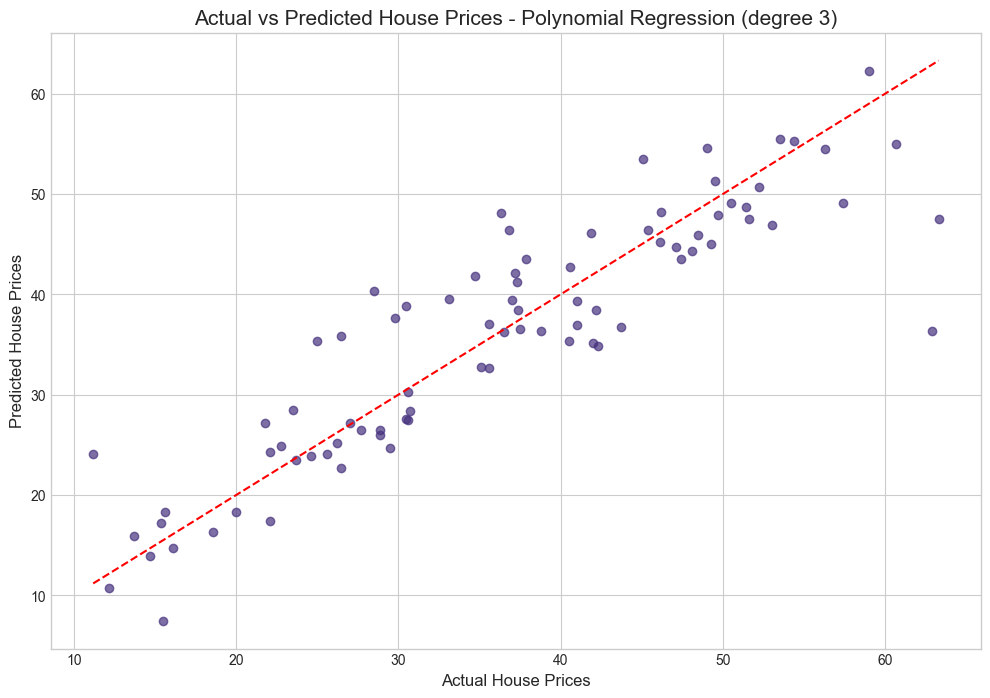

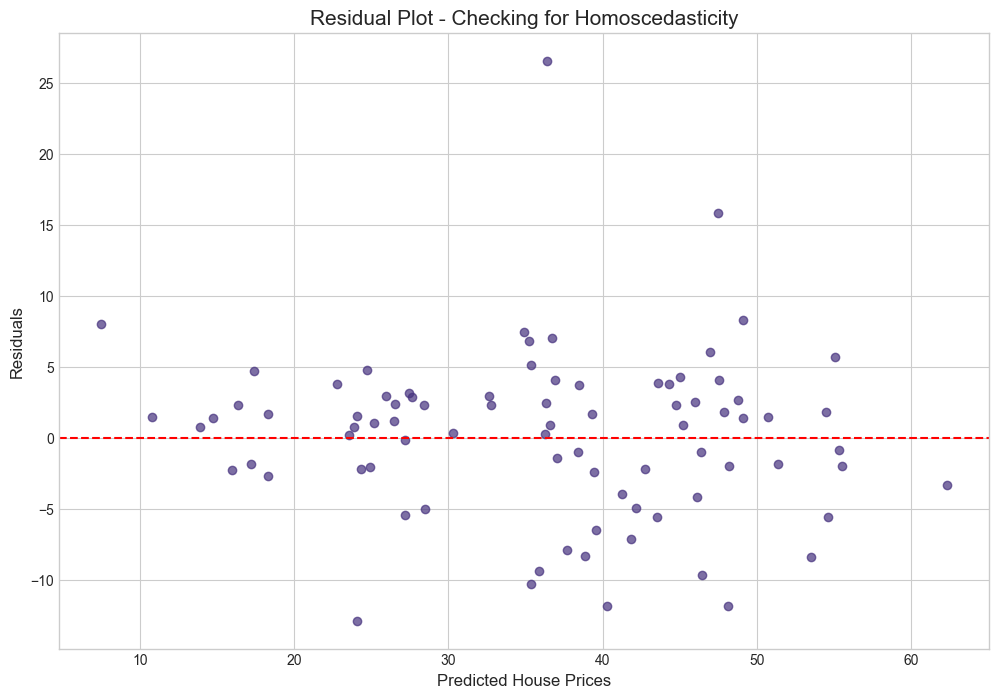

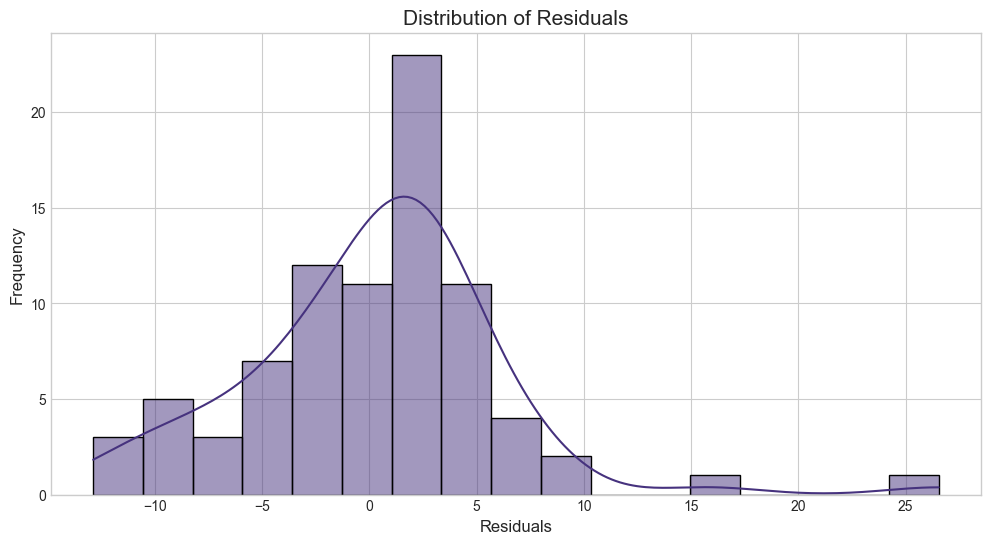

<Figure size 1000x600 with 0 Axes>

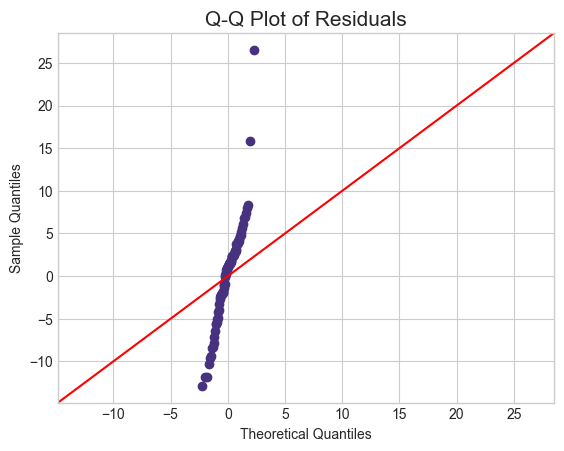

In [14]:
# =============================================================================
# MODEL EVALUATION
# =============================================================================

print("\n=== MODEL EVALUATION ===")

# Comprehensive evaluation of the best model
print(f"\nEvaluation of {best_model_name}:")

# Cross-validation for robustness check
cv_scores = cross_val_score(
    best_model, X_scaled_df, y_processed, 
    cv=5, scoring='r2'
)
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R²: {np.mean(cv_scores)}")
print(f"Standard Deviation of CV R²: {np.std(cv_scores)}")

# If the best model is a polynomial model, we need to use the pipeline
if 'Polynomial' in best_model_name:
    y_train_pred_best = best_model.predict(X_train)
    y_test_pred_best = best_model.predict(X_test)
else:
    y_train_pred_best = best_model.predict(X_train)
    y_test_pred_best = best_model.predict(X_test)

# Calculate evaluation metrics
train_r2 = r2_score(y_train, y_train_pred_best)
test_r2 = r2_score(y_test, y_test_pred_best)
train_mse = mean_squared_error(y_train, y_train_pred_best)
test_mse = mean_squared_error(y_test, y_test_pred_best)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train, y_train_pred_best)
test_mae = mean_absolute_error(y_test, y_test_pred_best)

print(f"\nTraining R²: {train_r2}")
print(f"Testing R²: {test_r2}")
print(f"Training MSE: {train_mse}")
print(f"Testing MSE: {test_mse}")
print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Testing MAE: {test_mae}")

# Visualize actual vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_test_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual House Prices', fontsize=12)
plt.ylabel('Predicted House Prices', fontsize=12)
plt.title(f'Actual vs Predicted House Prices - {best_model_name}', fontsize=15)
plt.show()

# Visualize residuals
residuals = y_test - y_test_pred_best
plt.figure(figsize=(12, 8))
plt.scatter(y_test_pred_best, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted House Prices', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot - Checking for Homoscedasticity', fontsize=15)
plt.show()

# Residual histogram
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Residuals', fontsize=15)
plt.show()

# QQ plot for residuals
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals', fontsize=15)
plt.show()

# Feature importance of the best model (if applicable)
if hasattr(best_model, 'coef_'):
    # For linear models
    if 'Polynomial' in best_model_name:
        # For polynomial models, it's complicated to interpret coefficients
        print("\nFor polynomial models, coefficients are not directly interpretable.")
    else:
        coef_df = pd.DataFrame({
            'Feature': X_processed.columns,
            'Coefficient': best_model.coef_
        })
        coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
        coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Coefficient', y='Feature', data=coef_df)
        plt.title(f'Feature Importance - {best_model_name}', fontsize=15)
        plt.xlabel('Coefficient Value', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.show()
        
        print("\nFeature Coefficients (Importance):")
        print(coef_df[['Feature', 'Coefficient']])

# Real Estate Valuation Model Analysis Report

## Executive Summary

This report analyzes a machine learning pipeline developed for predicting house prices in New Taipei City, Taiwan. The analysis covers data preprocessing, exploratory data analysis, feature selection, model development, and evaluation. The final polynomial regression model achieved a test R² of 0.794, indicating strong predictive capability for real estate valuation in the region.

## 1. Data Preprocessing & Exploratory Data Analysis

### Dataset Overview
The dataset contains 414 real estate transactions from Sindian District, New Taipei City, with 6 features and 1 target variable:
- Features: Transaction date, house age, distance to MRT station, number of convenience stores, latitude, and longitude
- <p>Target: House price per unit area (in 10,000 New Taiwan Dollar/Ping)<br><i>1 Ping = approximately 3.3 square meters (or about 35.6 square feet)</i></p>



### Data Quality Assessment
- **Completeness**: No missing values were detected in any columns
- **Outliers**: Outlier detection using IQR method identified:
  - 37 outliers in distance to MRT station
  - 8 outliers in latitude
  - 35 outliers in longitude
  - 3 outliers in house price
  - All outliers were handled by capping at IQR boundaries

### Distribution Analysis
- **Skewness Assessment**:
  - "Distance to MRT station" showed significant positive skewness (1.216)
  - Log transformation successfully reduced skewness to -0.094
  - Other features had acceptable skewness levels

### Feature Scaling
- Features were standardized to ensure comparability and improve model performance

### Correlation Analysis
The correlation with the target variable revealed:
- Strong negative correlation with distance to MRT station (-0.749)
- Strong positive correlation with number of convenience stores (0.599)
- Strong positive correlation with latitude (0.577)
- Moderate positive correlation with longitude (0.532)
- Weak negative correlation with house age (-0.216)
- Minimal correlation with transaction date (0.084)

This analysis provides clear evidence that proximity to MRT stations and convenience stores significantly impacts property values, aligning with urban development theories emphasizing the importance of accessibility to transportation and amenities.

## 2. Feature Selection and Engineering

### Feature Selection Approach
The analysis employed correlation-based feature selection, retaining all features due to their varying degrees of correlation with the target. The model coefficients from linear regression further confirmed the importance of each feature.

### Feature Transformation
- Log transformation was applied to "Distance to MRT station" to address skewness
- Feature scaling was implemented to standardize the range of variables

### Feature Importance Analysis
Based on linear regression coefficients:
1. Distance to MRT station (-7.177): Most influential feature with strong negative impact
2. Latitude (3.815): Second most influential with positive impact
3. House age (-2.799): Third most influential with negative impact
4. Transaction date (1.661): Moderate positive impact
5. Number of convenience stores (1.186): Moderate positive impact
6. Longitude (0.385): Least influential with slight positive impact

### Impact on Model Performance
- The transformation of the "Distance to MRT station" feature likely improved model performance by normalizing its distribution
- Retaining all features was justified as regularization methods (Ridge and Lasso) did not eliminate any features, suggesting all variables contribute meaningful information
- The polynomial feature engineering significantly improved model performance, increasing R² from 0.689 (linear) to 0.794 (polynomial degree 3)

## 3. Model Development and Hyperparameter Tuning

### Model Selection Process
The analysis evaluated four types of regression models:
1. **Multiple Linear Regression (Baseline)**
   - Training R²: 0.690
   - Testing R²: 0.731
   - Testing RMSE: 6.720

2. **Ridge Regression**
   - Hyperparameter tuning via cross-validation
   - Best alpha: 1
   - Training R²: 0.690
   - Testing R²: 0.731
   - Testing RMSE: 6.714
   - Minimal improvement over baseline

3. **Lasso Regression**
   - Hyperparameter tuning via cross-validation
   - Best alpha: 0.0001
   - Training R²: 0.690
   - Testing R²: 0.731
   - Testing RMSE: 6.720
   - No feature elimination (all coefficients non-zero)
   - Performance similar to baseline

4. **Polynomial Regression**
   - Degrees tested: 2 and 3
   - Degree 2: Testing R² of 0.776, RMSE of 6.134
   - Degree 3: Testing R² of 0.794, RMSE of 5.872
   - Significant improvement over linear models

### Hyperparameter Tuning Approach
- **Ridge and Lasso**: Cross-validation to determine optimal regularization strength (alpha)
- **Polynomial Regression**: Testing different polynomial degrees (2 and 3)

### Justification of Final Model Selection
Polynomial Regression (degree 3) was selected as the final model due to:
- Highest testing R² (0.794)
- Lowest testing RMSE (5.872)
- Ability to capture non-linear relationships between features and target
- Reasonable complexity without severe overfitting (difference between training R² of 0.816 and testing R² of 0.794 is acceptable)

## 4. Model Evaluation

### Performance Metrics
The final Polynomial Regression (degree 3) model achieved:
- **Training metrics**:
  - R²: 0.816
  - MSE: 31.663
  - RMSE: 5.627
  - MAE: 4.085

- **Testing metrics**:
  - R²: 0.794
  - MSE: 34.475
  - RMSE: 5.872
  - MAE: 4.260

- **Cross-validation**:
  - Mean CV R²: 0.669
  - Standard Deviation of CV R²: 0.077

### Interpretation of Model Performance
- **Explained Variance**: The R² of 0.794 indicates the model explains approximately 79.4% of the variance in house prices, which is strong for real estate prediction
- **Prediction Error**: RMSE of 5.872 (in 10,000 New Taiwan Dollar/Ping) represents the average prediction error
- **Cross-validation Stability**: The model shows some variability across folds (SD of 0.077), suggesting moderate dependence on the specific data split
- **Generalization**: The relatively small gap between training and testing R² (0.022) suggests good generalization without severe overfitting

### Comparative Analysis
- Polynomial Regression (degree 3) outperformed all other models:
  - 6.3% improvement in R² over linear regression
  - 12.6% reduction in RMSE compared to linear regression
  - Consistently better performance in both training and testing sets

## 5. Data-Driven Insights and Recommendations

### Key Findings

1. **Location Factors Dominate Price Determination**
   - Proximity to MRT stations is the strongest predictor of property value
   - Each standard deviation decrease in distance to MRT station increases property value by approximately 7.18 units (after accounting for polynomial terms)
   - Geographic coordinates (especially latitude) significantly influence pricing, indicating clear neighborhood value differentiation

2. **Accessibility to Amenities Drives Value**
   - Number of convenience stores shows strong positive correlation with property prices
   - Properties with more nearby convenience stores command higher prices, indicating the premium for convenience

3. **Property Characteristics Impact**
   - Newer properties tend to command higher prices (negative coefficient for house age)
   - The non-linear relationship captured by polynomial terms suggests complex interactions between property age and other factors

4. **Market Timing Influence**
   - Small positive coefficient for transaction date suggests slight market appreciation over the study period
   - The effect is relatively minor compared to location and property-specific factors

### Recommendations for Stakeholders

1. **For Investors and Buyers**:
   - Prioritize properties near MRT stations for better value retention and appreciation
   - Consider the number of convenience stores as a key indicator of potential property value
   - Balance the trade-off between property age and location advantages

2. **For Property Developers**:
   - Focus development in areas with good MRT access or planned future stations
   - Incorporate convenience store spaces in development plans to enhance property value
   - Consider the non-linear relationships between features when assessing potential development sites

3. **For Real Estate Professionals**:
   - Use the polynomial model for more accurate property valuation
   - Emphasize proximity to transportation and amenities in property marketing
   - Recognize that properties farther from MRT stations need other significant compensating factors to achieve comparable values

4. **For Policy Makers**:
   - Invest in expanding MRT network to increase property values in developing areas
   - Encourage mixed-use development that incorporates convenience stores and amenities
   - Consider the significant impact of transportation infrastructure on property tax base

### Model Improvement Opportunities

1. **Additional Features**:
   - Include school district information
   - Add property-specific features (floor level, view, building quality)
   - Incorporate neighborhood safety statistics

2. **Advanced Modeling Techniques**:
   - Explore ensemble methods (Random Forest, Gradient Boosting)
   - Consider spatial regression models to better capture geographic effects
   - Implement time series components to better model market trends

3. **More Sophisticated Feature Engineering**:
   - Create interaction terms between key features
   - Develop accessibility indices combining MRT distance and convenience stores
   - Generate neighborhood clusters based on geographic coordinates

## Conclusion

The developed polynomial regression model demonstrates strong predictive capability for real estate valuation in New Taipei City. The analysis confirms the critical importance of location factors, particularly proximity to public transportation and conveniences, in determining property values. The model's performance (R² of 0.794) provides stakeholders with a reliable tool for property valuation while highlighting the complex, non-linear relationships that exist in real estate markets.
